In [1]:
#!pip install matplotlib
#!pip install scipy
#!pip install networkx
#!pip install seaborn
#!pip install scikit-learn


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
#import statsmodels.api as sm

# for type hinting
#from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx


#from matplotlib.lines import Line2D
#from matplotlib.text import Annotation
#import seaborn as sns

# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison, getKDEDensity, getDistributionBins, kde_mutual_information, drop_static_columns, performFourierAndLimitHarmonics, scaler_sec_midnight, save_component, load_component, calculate_phase_and_time_difference

See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [4]:
# windows
csv_path = "/home/loz/MSc/MSc_Project/SWaT DataSWaT 2015-12-23.csv"
converted_path = "/home/loz/MSc/MSc_Project/SWaT_12_23_sec_orig.csv"
# ubuntu
#csv_path = "/home/loz/Documents/GitHub/MSc-Project/SWaT DataSWaT 2015-12-23.csv"
#converted_path = "/home/loz/Documents/GitHub/MSc-Project/SWaT_12_23_sec_minmax.csv"

# dataset with original values for step size etc
df_orig = pd.read_csv(csv_path, index_col='time_in_seconds')

#df_orig.columns
# drop time columns and use normal index as 1 second increments anyway
#df_orig = df_orig.drop(columns=['Timestamp', 'time', 'date'])
# call function to normalise and covert timestamp to seconds since midnight
#df_norm_sec = scaler_sec_midnight(csv_path, converted_path, scaler_type='minmax')  

# dataset with minmax scaled values
df_norm_sec = pd.read_csv(converted_path, index_col='time_in_seconds')

df= df_norm_sec.copy()
#df_norm_sec

# Create Component Object for Each Component in SWaT Data

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [5]:
# iterate through every column and create object of component class
# dictionary for all component objects
# intialise from original data- not normalised
components = {}
for n, component in enumerate(df_orig.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n, df_orig=df_orig)


/home/loz/MSc/MSc_Project/final_code/component_module.py:68: RuntimeWarning: invalid value encountered in scalar divide
  norm_step_size = step_size/ (max_value - min_value)
/home/loz/MSc/MSc_Project/final_code/component_module.py:72: RuntimeWarning: invalid value encountered in scalar divide
  change_ratio = value_range / step_size


In [6]:
components['LIT101'].change_ratio

150.18229379918944

# Make Matrices then update object for each component

### Calculate the linear (Pearson) correlation matrix

In [7]:
# set linear correaltion attribute

#if df.index.name != 'Timestamp':
#    df = df.set_index('Timestamp')


# Calculate the linear correlation matrix
correlation_matrix = df.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with every other column
    for col2 in df.columns:
        correlation_coefficient, p_value = pearsonr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



In [8]:
#correlation_matrix_styled

### Assign relevant linear correllation values to each component object

In [9]:
# Set Component objects values
for component_name, component_obj in components.items():
    if component_name in correlation_matrix.index:
        # Convert correlation coefficient row to dict
        correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name]) if col != component_name }
        component_obj.correlation_dict = correlation_dict
        #print(component_name, component_obj.correlation_dict )

    if component_name in p_values.index:
        # Convert p-value row to dict
        p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
        #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
        component_obj.p_value_dict = p_value_dict

# Non-Linear Correlation of Components
The previous stage looked for linear correlation between components, other non- linear methods were evaluated as the complex interplay of componets could lead to non-linear behaviour even with pairwise linear relationships. These methods look for monatonic relationships- the values for two components consistently change together ( positive or negative).

### Calculate the correlation matrix using Spearman's rank correlation

In [10]:
# Calculate the correlation matrix using Spearman's rank correlation
non_lin_correlation_matrix = df.corr(method='spearman').round(decimals=4)

# DataFrame to store p-values with rows and cols being column names
non_lin_p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with every other column
    for col2 in df.columns:
        correlation_coefficient, p_value = spearmanr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        non_lin_p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
non_lin_correlation_matrix_styled = non_lin_correlation_matrix.style.background_gradient(cmap='coolwarm')
non_lin_p_values_styled = non_lin_p_values.style.background_gradient(cmap='coolwarm').format(precision=2)


In [11]:
#non_lin_correlation_dict

### Assign relevant non-linear correlation values to each component object

In [12]:
for component_name, component_obj in components.items():
     if component_name in non_lin_correlation_matrix.index:
        # Convert correlation coefficient row to dict
        non_lin_correlation_dict = {col: value for col, value in zip(non_lin_correlation_matrix.columns, non_lin_correlation_matrix.loc[component_name]) if col != component_name}
        component_obj.non_lin_correlation_dict = non_lin_correlation_dict
        #print(component_name, component_obj.non_lin_correlation_dict )
         
     if component_name in non_lin_p_values.index:      
        # Convert p-value row to dict
        non_lin_p_value_dict = {col: value for col, value in zip(non_lin_p_values.columns, non_lin_p_values.loc[component_name])}
        #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
        component_obj.non_lin_p_value_dict = non_lin_p_value_dict

# Kernel Distributions

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

In [13]:
#df['LIT101']

Var Range:  0.9999999999999998


/home/loz/MSc/MSc_Project/final_code/component_module.py:513: RuntimeWarning: divide by zero encountered in scalar divide
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

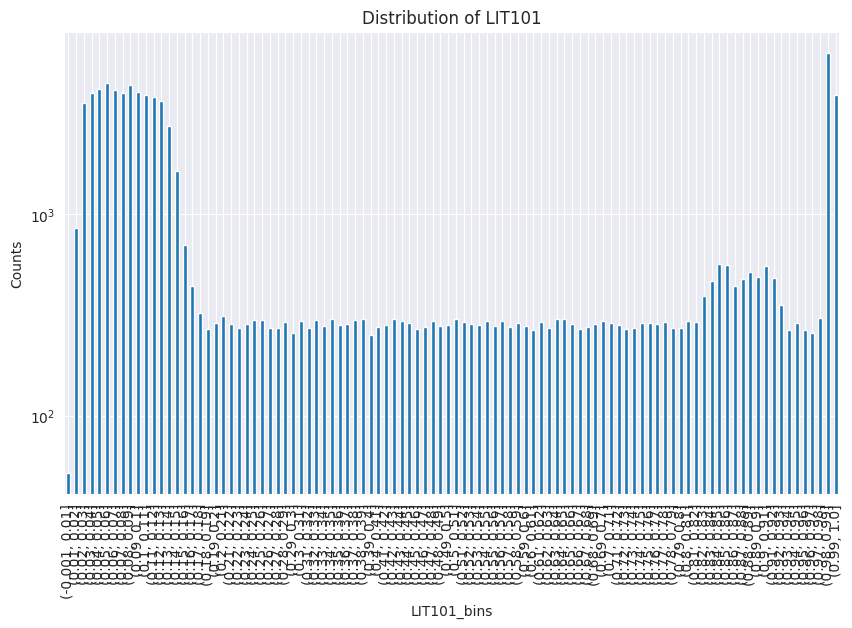

In [14]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistributionBins(df, 'LIT101')

In [ ]:
getKDEDensity(df, 'LIT101', save_path='D:\GitHub\MSc-Project-March\Write_Up\Charts\lit_101_kde_plot.jpeg')

In [ ]:
getKDEDensity(df, 'MV101')

# Calculate mutual information between features
mutual_info_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate mutual information
for col1 in df.columns:
    for col2 in df.columns:
        mutual_info = mutual_info_regression(df[[col1]], df[col2])[0]
        mutual_info_matrix.loc[col1, col2] = mutual_info

# Display the mutual information matrix
print(mutual_info_matrix)


# using scaled already
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)

In [15]:
#mi_lit101 = kde_mutual_information(df_normalised, 'LIT101', num_points=100, n_jobs=-1)
#print(mi_lit101)

# slow so son't re-run. Import df instead

mi_results_df = pd.DataFrame()
for component_name, component_obj in components.items():

    try:
        mi_results = kde_mutual_information(df_normalised, component_name, num_points=100, n_jobs=-1)
        mi_results_df[component_name] = mi_results
    except Exception as e:
        # In case of error, add a column of NaNs
        mi_results_df[component_name] = np.nan
        print(f"Error calculating MI for {component_name}: {e}")

    print(f"Finished:{component_name}")

# Transpose the result to make each row represent a component and each column an MI score
mi_results_df = mi_results_df.T

# Fill any missing values (optional, this step is already handled)
mi_results_df.fillna(np.nan, inplace=True)

# Print the final DataFrame
print(mi_results_df)

In [16]:
#mi_results_df.to_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv', index=False)

In [20]:
# get previously run results
#mi_results_df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv')
# ubuntu
mi_results_df = pd.read_csv('/home/loz/MSc/MSc_Project/SWaT Data/mi_results.csv')

In [21]:
mi_results_df.rename(columns={'Unnamed: 0':'Component'}, inplace=True)
mi_results_df.set_index('Component', inplace=True)
mi_results_df.index

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203',
       'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301',
       'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503',
       'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P602'],
      dtype='object', name='Component')

In [22]:
#mi_results_df

In [23]:
#components

In [59]:
# set mi attribute with dict for each component
for component_name, component in components.items():
    if component_name in mi_results_df.columns:
        component.mutual_info_dict = mi_results_df[component_name]
    else:
        component.mutual_info_dict = {}


1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

# Calculate FFT and set Phase & Time Difference

In [60]:
#calculate_phase_and_time_difference(df_orig, 'LIT101', 'FIT101')
# make dict with every componet with a list of dict with phase diff for every other component where posssible
phase_dict = {}
for col_1 in df_orig.columns:
    phase_dict[col_1] = {}
    for col_2 in df_orig.columns:
        try:
            phase, time_diff = calculate_phase_and_time_difference(df_orig, col_1, col_2)
            phase_dict[col_1][col_2] = {'phase': phase, 'time_diff': time_diff}
        # catch errors in missing values etc
        except Exception as e:
            phase_dict[col_1][col_2] = {'phase': 9999, 'time_diff': 9999}

phase_dict['LIT101']
phase_dict['LIT101']['FIT503']

/home/loz/MSc/MSc_Project/final_code/component_module.py:812: RuntimeWarning: divide by zero encountered in scalar divide
  time_difference = phase_difference / (2 * np.pi * avg_freq)


{'phase': 2.0303257741907172, 'time_diff': 2233.5186796369826}

In [61]:
# sort values
for key, value in phase_dict.items(): 
    
    # check for dict  
    if isinstance(value, dict):    
        # sort
        sorted_items = sorted(value.items(), key=lambda x: x[1]['time_diff'])
        
        # back to dict
        phase_dict[key] = dict(sorted_items) 


In [62]:
# set wave_diff_dict attribute of each component
for component_name, component_obj in components.items():
    if component_name in phase_dict.keys():
        
        # drop self comparison
        wave_diff_dict = {col: value for col, value in phase_dict[component_name].items() if col != component_name}
        # set attribute
        component_obj.wave_diff_dict = wave_diff_dict
    else:
        # set an empty dict as default
        print(component_name)
        component_obj.wave_diff_dict = {}


In [63]:
components['LIT101'].wave_diff_dict

{'MV302': {'phase': 3.0784821702536207, 'time_diff': -4031.6351008412935},
 'P602': {'phase': -2.608830535392224, 'time_diff': -1793.6997497139528},
 'FIT301': {'phase': -2.4813617108210613, 'time_diff': -1706.0586417048994},
 'PIT502': {'phase': -1.2526555246729587, 'time_diff': -1497.847820817523},
 'AIT203': {'phase': -1.1460466357619095, 'time_diff': -1370.3715204380692},
 'AIT501': {'phase': -1.1981514606161852, 'time_diff': -1318.0612206862559},
 'AIT504': {'phase': -0.9051393936441574, 'time_diff': -1131.5054645856146},
 'FIT502': {'phase': -0.9625901744355627, 'time_diff': -1058.9252044016537},
 'DPIT301': {'phase': -2.158923040416133, 'time_diff': -973.354847287051},
 'AIT201': {'phase': -1.049789438411084, 'time_diff': -962.3760671738239},
 'P302': {'phase': -2.0964077833016534, 'time_diff': -945.1697163663833},
 'AIT202': {'phase': -1.8041079100036126, 'time_diff': -708.8075590585698},
 'MV304': {'phase': -2.5364781603950304, 'time_diff': -147.48024702011904},
 'MV301': {'ph

In [28]:
#components['LIT101'].wave_diff_dict
#df_lit_phase = pd.DataFrame(components['LIT101'].wave_diff_dict.T)
#df_lit_phase = df_lit_phase.T
#df_lit_phase = df_lit_phase.round(decimals= 2)

In [29]:
#df_lit_cut = df_lit_phase.iloc[10:18]
#df_lit_cut

In [30]:
#sorted_phase_MV101 = sorted(phase_dict['MV101'], key=lambda x: x['time_diff'])
#f_phase = pd.DataFrame(sorted_phase_MV101)
#df_phase.loc['P101',]
#df_phase.iloc[20:30,]

In [31]:
switch_ratio(components['FIT101'])

NameError: name 'switch_ratio' is not defined

# Serialising Component Objects

In [64]:
object_saves = {}
path = '/home/loz/MSc/MSc_Project/final_code/component_objs'
for component_name, component_obj in components.items():    
    filename = path + component_name
    save_component(component_obj, filename)
    object_saves[component_name] = filename

object_saves[component_name] = filename
component_filename = pd.DataFrame.from_dict(object_saves, orient='index', columns=['filename'])
component_filename.to_csv(path + 'component_filenames.csv', index=True)

Component 'FIT101' saved to /home/loz/MSc/MSc_Project/final_code/component_objsFIT101.
Component 'LIT101' saved to /home/loz/MSc/MSc_Project/final_code/component_objsLIT101.
Component 'MV101' saved to /home/loz/MSc/MSc_Project/final_code/component_objsMV101.
Component 'P101' saved to /home/loz/MSc/MSc_Project/final_code/component_objsP101.
Component 'P102' saved to /home/loz/MSc/MSc_Project/final_code/component_objsP102.
Component 'AIT201' saved to /home/loz/MSc/MSc_Project/final_code/component_objsAIT201.
Component 'AIT202' saved to /home/loz/MSc/MSc_Project/final_code/component_objsAIT202.
Component 'AIT203' saved to /home/loz/MSc/MSc_Project/final_code/component_objsAIT203.
Component 'FIT201' saved to /home/loz/MSc/MSc_Project/final_code/component_objsFIT201.
Component 'MV201' saved to /home/loz/MSc/MSc_Project/final_code/component_objsMV201.
Component 'P201' saved to /home/loz/MSc/MSc_Project/final_code/component_objsP201.
Component 'P202' saved to /home/loz/MSc/MSc_Project/final_c

In [65]:
#path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/'
#path = '/home/loz/MSc/MSc_Project/final_code/component_objs/'


df_comp_files = pd.read_csv(path + 'component_filenames.csv', index_col=0)
components = {}
for component_name, filename in df_comp_files['filename'].items():    
    # put returned component object into dict
    components[component_name] = load_component(filename)

Component 'FIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsFIT101.
Component 'LIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsLIT101.
Component 'MV101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsMV101.
Component 'P101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsP101.
Component 'P102' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsP102.
Component 'AIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsAIT201.
Component 'AIT202' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsAIT202.
Component 'AIT203' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsAIT203.
Component 'FIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsFIT201.
Component 'MV201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsMV201.
Component 'P201' has b

In [66]:
components['LIT101'].mutual_info_dict

Component
FIT101       6.930098
LIT101            NaN
MV101        6.460144
P101         6.997855
AIT201       2.246728
AIT202      11.635775
AIT203       8.625869
FIT201       6.969463
MV201        7.436206
P203         6.994789
P205         6.998430
DPIT301      5.276992
FIT301       5.978915
LIT301       5.115845
MV301       26.010566
MV302        6.938717
MV303       11.520720
MV304       13.205717
P301       119.486524
P302         6.179314
AIT401      36.106187
AIT402       8.627242
FIT401      85.786212
LIT401       5.014222
P402        46.286453
UV401             inf
AIT501       5.165579
AIT502       8.745994
AIT503       3.374725
AIT504      38.699792
FIT501      82.113939
FIT502      17.970737
FIT503      45.918802
FIT504     249.880251
P501              inf
PIT501      47.039659
PIT502      21.273287
PIT503            inf
FIT601      12.196271
P602        15.859432
Name: LIT101, dtype: float64

In [ ]:
components_loaded

In [ ]:
#df_comp_files

In [67]:
df_comp_files = pd.read_csv(path + 'component_filenames.csv', index_col=0)
components_loaded = {}
for component_name, filename in df_comp_files['filename'].items():    
    # put returned component object into dict
    components_loaded[component_name] = load_component(filename)
    #print(filename)

Component 'FIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsFIT101.
Component 'LIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsLIT101.
Component 'MV101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsMV101.
Component 'P101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsP101.
Component 'P102' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsP102.
Component 'AIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsAIT201.
Component 'AIT202' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsAIT202.
Component 'AIT203' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsAIT203.
Component 'FIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsFIT201.
Component 'MV201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objsMV201.
Component 'P201' has b

In [68]:
components_loaded['LIT101'].mutual_info_dict

Component
FIT101       6.930098
LIT101            NaN
MV101        6.460144
P101         6.997855
AIT201       2.246728
AIT202      11.635775
AIT203       8.625869
FIT201       6.969463
MV201        7.436206
P203         6.994789
P205         6.998430
DPIT301      5.276992
FIT301       5.978915
LIT301       5.115845
MV301       26.010566
MV302        6.938717
MV303       11.520720
MV304       13.205717
P301       119.486524
P302         6.179314
AIT401      36.106187
AIT402       8.627242
FIT401      85.786212
LIT401       5.014222
P402        46.286453
UV401             inf
AIT501       5.165579
AIT502       8.745994
AIT503       3.374725
AIT504      38.699792
FIT501      82.113939
FIT502      17.970737
FIT503      45.918802
FIT504     249.880251
P501              inf
PIT501      47.039659
PIT502      21.273287
PIT503            inf
FIT601      12.196271
P602        15.859432
Name: LIT101, dtype: float64

In [ ]:
components_loaded.keys()

In [ ]:
#components_loaded['LIT101'].max_value

In [ ]:
#components['LIT101'].max_value

# get  component objects
path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/'
df_comp_files = pd.read_csv(os.path.join(path + 'component_filenames.csv'), index_col=0)
components = {}
for component_name, row in df_comp_files.iterrows():  
    filename = row['filename'] 
    # put returned component object into dict
    components[component_name] = load_component(filename)

# Component Relationship Overview

In [35]:
comp_dict = {}
for name, values in zip(['Mutual Info', 'Linear Cor', 'Non Linear Cor'], [top_mi, top_lin_cor, top_non_lin_cor]):
    comp_dict[name] = values
data = pd.DataFrame(comp_dict)
data.head(10)

NameError: name 'top_mi' is not defined